Episode 1/1000, Total Reward: 26
Episode 2/1000, Total Reward: 15
Episode 3/1000, Total Reward: 6
Episode 4/1000, Total Reward: -11
Episode 5/1000, Total Reward: 4
Episode 6/1000, Total Reward: 10
Episode 7/1000, Total Reward: 7
Episode 8/1000, Total Reward: 1
Episode 9/1000, Total Reward: 15
Episode 10/1000, Total Reward: 6
Episode 11/1000, Total Reward: 5
Episode 12/1000, Total Reward: -1
Episode 13/1000, Total Reward: 2
Episode 14/1000, Total Reward: 17
Episode 15/1000, Total Reward: 27
Episode 16/1000, Total Reward: -5
Episode 17/1000, Total Reward: 2
Episode 18/1000, Total Reward: 2
Episode 19/1000, Total Reward: 14
Episode 20/1000, Total Reward: -1
Episode 21/1000, Total Reward: 33
Episode 22/1000, Total Reward: 203
Episode 23/1000, Total Reward: 200
Episode 24/1000, Total Reward: 147
Episode 25/1000, Total Reward: 154
Episode 26/1000, Total Reward: 103
Episode 27/1000, Total Reward: 76
Episode 28/1000, Total Reward: 109
Episode 29/1000, Total Reward: 105
Episode 30/1000, Total R

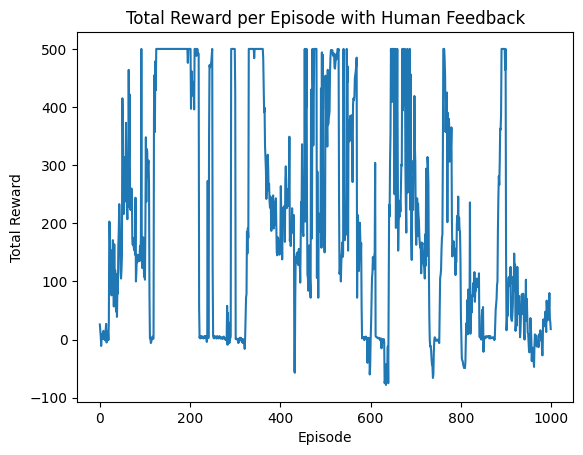

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=10000, batch_size=64, target_update=10):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = DQN(self.state_dim, self.action_dim)
        self.target_model = DQN(self.state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)
        self.update_target_model()
        self.target_update = target_update
        self.steps_done = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.FloatTensor(state_batch)
        action_batch = torch.LongTensor(action_batch).unsqueeze(1)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1)
        next_state_batch = torch.FloatTensor(next_state_batch)
        done_batch = torch.FloatTensor(done_batch).unsqueeze(1)

        q_values = self.model(state_batch).gather(1, action_batch)
        next_q_values = self.target_model(next_state_batch).max(1)[0].unsqueeze(1)
        target_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def get_human_feedback(self, state, action):
        # Simulate human feedback
        feedback = -1 if abs(state[2]) > 0.1 else 1
        return feedback

def train(env, agent, episodes):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            feedback = agent.get_human_feedback(state, action)
            agent.remember(state, action, feedback, next_state, done)
            agent.replay()
            state = next_state
            total_reward += feedback

            if episode % agent.target_update == 0:
                agent.update_target_model()

        rewards.append(total_reward)
        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
    return rewards

# Main function to run the training
def main():
    env = gym.make('CartPole-v1')
    agent = DQNAgent(env)
    episodes = 1000  # Increased number of episodes
    rewards = train(env, agent, episodes)

    # Plot the rewards
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode with Human Feedback')
    plt.show()

if __name__ == "__main__":
    main()
